In [1]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np
import random
import scipy.ndimage as scim
import imageio
import math
from skimage import transform
import pandas as pd

# Deep Learning Librairies
import tensorflow as tf

In [2]:
print(tf.__version__) 

2.4.0


In [3]:
# !tar -czf resized_dataset.tar.gz resized_dataset

In [4]:
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.backend as k
import tensorflow.keras.models as km
import tensorflow.keras.applications as ka
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, concatenate

# Data visualization
from matplotlib import pyplot as plt

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12333363104483900360
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10421028800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17681617571259804624
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


# I - Baseline model 

In [6]:
data_dir_sub = './landscapes'

In [8]:
img_width = 120
img_height = 120

We implement the datagenerators for both training and validation datasets :

In [9]:
# this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir_sub+"/train/",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='sparse')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir_sub+"/valid/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='sparse')

Found 3067 images belonging to 7 classes.
Found 714 images belonging to 7 classes.


In [10]:
N_train = 3067
N_val = 714

### Baseline model architecture

To evaluate the efficiency of context learning we first train a model using supervised learning that will serve as an optimal reference. 

We define the CNN model using 3 different parts :
- low features : Will serve as a comparison with the context learning method
- top features : A few convolutional layers
- classifier : fully connected neurons

In [11]:
low_baseline = km.Sequential(name = "low_features")

low_baseline.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last", padding="same"))
low_baseline.add(kl.Activation('relu'))
low_baseline.add(kl.Conv2D(32, (3, 3), padding="same"))
low_baseline.add(kl.Activation('relu'))
low_baseline.add(kl.MaxPooling2D(pool_size=(2, 2)))

low_baseline.add(kl.Conv2D(32, (3, 3), padding="same"))
low_baseline.add(kl.Activation('relu'))
low_baseline.add(kl.Conv2D(32, (3, 3), padding="same"))
low_baseline.add(kl.Activation('relu'))
low_baseline.add(kl.MaxPooling2D(pool_size=(2, 2)))

In [12]:
top_baseline = km.Sequential(name = "top_features")

top_baseline.add(kl.Conv2D(64, (3, 3), padding="same"))
top_baseline.add(kl.Activation('relu'))
top_baseline.add(kl.Conv2D(64, (3, 3), padding="same"))
top_baseline.add(kl.Activation('relu'))
top_baseline.add(kl.MaxPooling2D(pool_size=(2, 2)))

In [13]:
classif_baseline = km.Sequential(name = "classifier")

classif_baseline.add(kl.Dense(128))
classif_baseline.add(kl.Activation('relu'))
classif_baseline.add(kl.Dense(64))
classif_baseline.add(kl.Activation('relu'))
classif_baseline.add(kl.Dropout(0.5))
classif_baseline.add(kl.Dense(7))
classif_baseline.add(kl.Activation('softmax'))

In [14]:
model_baseline = km.Sequential()

model_baseline.add(low_baseline)
model_baseline.add(top_baseline)
model_baseline.add(kl.Flatten())
model_baseline.add(classif_baseline)

In [15]:
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
low_features (Sequential)    (None, 30, 30, 32)        28640     
_________________________________________________________________
top_features (Sequential)    (None, 15, 15, 64)        55424     
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
classifier (Sequential)      (None, 7)                 1852039   
Total params: 1,936,103
Trainable params: 1,936,103
Non-trainable params: 0
_________________________________________________________________


### Training of the baseline model

In [7]:
epochs = 10
batch_size=20

In [16]:
model_baseline.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
ts = time.time()
model_baseline.fit(train_generator, steps_per_epoch= N_train // batch_size, epochs=epochs, 
                         validation_data=validation_generator,validation_steps=N_val // batch_size)
te = time.time()
t_learning = te-ts
print("Learning Time for %d epochs : %d seconds"%(epochs,t_learning))

Epoch 1/10
153/153 [==============================] - 36s 200ms/step - loss: 1.7644 - accuracy: 0.2747 - val_loss: 1.4080 - val_accuracy: 0.4529
Epoch 2/10
153/153 [==============================] - 11s 70ms/step - loss: 1.4004 - accuracy: 0.4627 - val_loss: 1.1930 - val_accuracy: 0.5257
Epoch 3/10
153/153 [==============================] - 11s 71ms/step - loss: 1.2881 - accuracy: 0.4989 - val_loss: 1.3262 - val_accuracy: 0.4943
Epoch 4/10
153/153 [==============================] - 11s 69ms/step - loss: 1.1526 - accuracy: 0.5825 - val_loss: 0.9228 - val_accuracy: 0.6729
Epoch 5/10
153/153 [==============================] - 11s 69ms/step - loss: 0.9196 - accuracy: 0.6669 - val_loss: 0.8078 - val_accuracy: 0.7071
Epoch 6/10
153/153 [==============================] - 11s 69ms/step - loss: 0.8385 - accuracy: 0.6906 - val_loss: 0.7810 - val_accuracy: 0.7086
Epoch 7/10
153/153 [==============================] - 11s 69ms/step - loss: 0.7152 - accuracy: 0.7486 - val_loss: 0.8180 - val_accuracy

### Predictions and results (baseline model)

In [18]:
y_true = []
y_pred = []
for i in range(N_val//batch_size):
    X_val_batch , y_true_batch = next(iter(validation_generator))
    y_pred_batch = model_baseline.predict(X_val_batch)

    y_true = np.concatenate((y_true,y_true_batch))
    y_pred = np.concatenate((y_pred ,np.argmax(y_pred_batch, axis = 1)))

In [19]:
classes = np.array(['city', 'field', 'forest', 'lake', 'ocean', 'mountain', 'road'])

In [20]:
y_true_ = classes[y_true.astype('int')]
y_pred_ = classes[y_pred.astype('int')]
pd.crosstab(y_true_, y_pred_, rownames = ['Y true'], colnames = ['Y pred'])

Y pred,city,field,forest,lake,mountain,ocean,road
Y true,,,,,,,
city,48,1,7,0,0,7,3
field,2,51,5,6,0,26,5
forest,2,2,118,1,0,0,0
lake,0,1,1,81,9,14,4
mountain,0,0,0,8,37,37,0
ocean,5,2,1,2,4,114,2
road,0,0,3,11,0,12,68


In [21]:
print("Accuracy (validation set) : ", 100*np.sum(1*(y_true==y_pred))/len(y_true), "%")

Accuracy (validation set) :  73.85714285714286 %


# II - Patch positioning

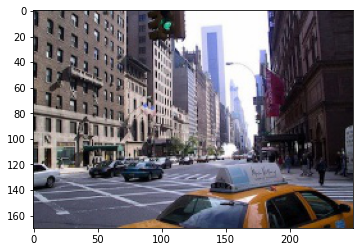

In [23]:
im = (imageio.imread('./landscapes/valid/city/3715538_4fc63bc071.jpg'))[:,:,:3]
plt.imshow(im)

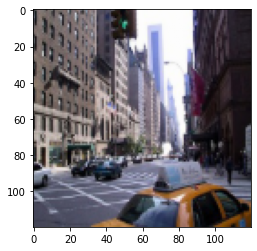

In [39]:
img_shape = (120,120,3)
image = transform.resize(im, img_shape)
plt.imshow(image)

### Transforming input image (to be used or not to be used)

In [25]:
# image preprocessing.  Note that the input image will be modified.
def prep_image(im):
  origsz=im.shape
  # for some patches, randomly downsample to as little as 100 total pixels
  if(random.random() < .33):
    
    randpix=int(math.sqrt(random.random() * (95 * 95 - 10 * 10) + 10 * 10))
      

    # im=scim.resize(im.astype(np.uint8), (randpix, randpix))
    # im=(scim.resize(im, (origsz[0], origsz[1])) * 255).astype(np.float32)
    im=transform.resize(im, (randpix, randpix))
  im=transform.resize(im, (origsz[0], origsz[1])) # Useless if no downsampling but transforms [0,255] to [0,1]

  # randomly drop all but one color channel
  chantokeep=random.randint(0, 2)
  #print(chantokeep)
  # mean=[123, 117, 104]
  for i in range(0, 3):
    if i==chantokeep:
      im[:,:,i] = im[:,:,i] 
    else:
      im[:,:,i]= np.random.uniform(0, 1/255, (im.shape[0], im.shape[1])) + 0.5 # noised complentary at 128/128/0 intensity
      #im[:,:,i] = np.zeros((im.shape[0], im.shape[1]))
  # Normalize the mean and variance so that gradients are a less useful cue;
  # then scale by 50 so that the variance is roughly the same as the usual
  # AlexNet inputs.
  #im=im / np.sqrt(np.mean(np.square(im))) * 50
  return im
  #return im.transpose(2, 0, 1)

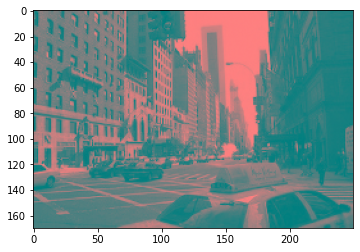

In [26]:
im_preproc = prep_image(im)
plt.imshow(im_preproc)

### Generating patches

In [28]:
patch_sz=(32,32) # size of sampled patches
gap = 8         # gap between patches
noise = 2        # jitter by at most this many pixels

In [29]:
def sample_patch(x, y, gridstartx, gridstarty, patch_sz, gap, noisehalf, 
                 im_shape):
  xpix = gridstartx + x * (patch_sz[1] + gap) \
         + random.randint(-noisehalf, noisehalf)
  xpix2 = min(max(xpix, 0), im_shape[1] - patch_sz[1])
  ypix = gridstarty + y * (patch_sz[0] + gap) \
         + random.randint(-noisehalf, noisehalf)
  ypix2 = min(max(ypix, 0), im_shape[0] - patch_sz[0])
  assert abs(xpix - xpix2) < gap
  assert abs(ypix - ypix2) < gap
  return (xpix2 , ypix2)

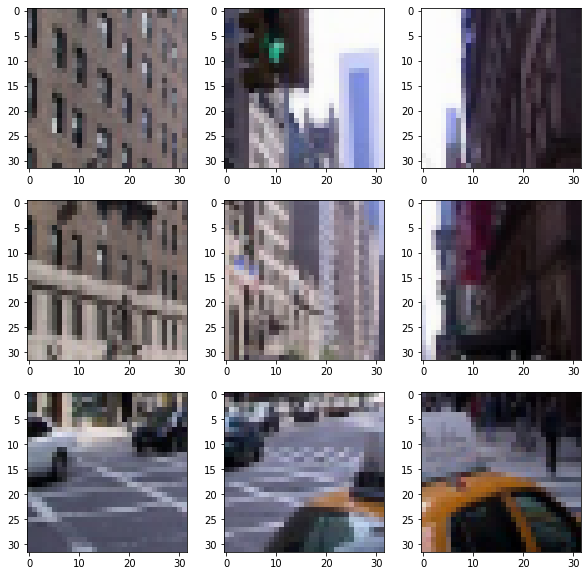

In [30]:
height = 3
width = 3
fig, ax = plt.subplots(height,width, figsize = (10,10))
for i in range(height):
    for j in range(width):
        x_deb_patch, y_deb_patch = sample_patch(i,j,0,0, patch_sz, gap, noise, img_shape)
        x_fin_patch = x_deb_patch + patch_sz[0]
        y_fin_patch = y_deb_patch + patch_sz[1]
        plt.sca(ax[i][j])
        plt.imshow(image[x_deb_patch:x_fin_patch, y_deb_patch:y_fin_patch, :])
plt.show()

### Function generating Y vector for the patch locator

In [36]:
# 0 | 1 | 2
# 3 | X | 4
# 5 | 6 | 7

def pos_to_indices(p=0):
    if p <= 2:
        ind = [0,p]
    elif p >=5:
        ind = [2,p-5]
    elif p == 3 or p == 4:
        ind = [1, (p-3)*2]
    return (ind)


for p in range(8):
    print(p, "->",pos_to_indices(p))

0 -> [0, 0]
1 -> [0, 1]
2 -> [0, 2]
3 -> [1, 0]
4 -> [1, 2]
5 -> [2, 0]
6 -> [2, 1]
7 -> [2, 2]


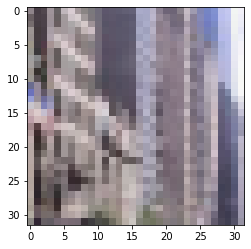

Relative position: 4


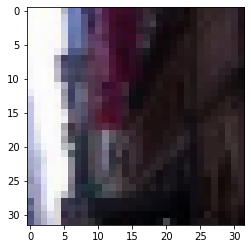

In [40]:
def patch_duo_and_pos(im, pos = 0, patch_sz = patch_sz, gap=gap, noise=noise, img_shape=img_shape): # pos in [0..7]
    
    new_im = transform.resize(im, img_shape)
    
    x_deb_patch, y_deb_patch = sample_patch(1,1,0,0, patch_sz, gap, noise, img_shape)
    x_fin_patch = x_deb_patch + patch_sz[0]
    y_fin_patch = y_deb_patch + patch_sz[1]
    patch1 = new_im[x_deb_patch:x_fin_patch, y_deb_patch:y_fin_patch, :]
    
    ind_pos = pos_to_indices(pos)
    ind_x = ind_pos[0]
    ind_y = ind_pos[1] 

    x_deb_patch, y_deb_patch = sample_patch(ind_x,ind_y,0,0, patch_sz, gap, noise, img_shape)
    x_fin_patch = x_deb_patch + patch_sz[0]
    y_fin_patch = y_deb_patch + patch_sz[1]
    patch2 = new_im[x_deb_patch:x_fin_patch, y_deb_patch:y_fin_patch, :]

    return [patch1, patch2] , pos

patches, y = patch_duo_and_pos(image, pos = 4)
plt.figure()
plt.imshow(patches[0])
plt.show()
plt.imshow(patches[1])
print("Relative position:", y)

In [41]:
def gen_altered_patches(im, pos=0):
    # new_im = prep_image(im) à décommenter ??????????????????????
    new_im = im
    return patch_duo_and_pos(new_im, pos)

### Data generator for patches

In [42]:
# Deep Learning Librairies

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df_paths,
                 batch_size,
                 patch_size=(None,None,None),
                 shuffle=True,
                 preprocessing_function = None):
        
        self.df = df_paths
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.shuffle = shuffle
        self.preprocessing_function = preprocessing_function
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    
    def _get_data(self, batch):
        # List of paths for X
        batch_X_paths = batch.iloc[:,0]
        batch_X_shape = [self.batch_size]+ [2] + list(self.patch_size)
        batch_X = np.zeros(batch_X_shape)
        batch_y = np.zeros(self.batch_size)
        for i, file_path in enumerate(batch_X_paths):
            im = (imageio.imread(file_path))[:,:,:3]
            pos = np.random.randint(0,7)
            patches, yi = self.preprocessing_function(im, pos)
            batch_X[i,:,:,:,:] = patches
            batch_y[i] = yi
        return batch_X, batch_y


    def __getitem__(self, index): # Retrieve entire batch of given index 
        batch = self.df[index * self.batch_size:(index + 1) * self.batch_size]   # Paths for X values for batch of given index
        X, y = self._get_data(batch)  
        return X, y
    
    def __len__(self): 
        return self.n // self.batch_size
     

### Creating dataframe with paths

In [57]:
paths_train = []
for r,d,f in os.walk('./landscapes/train'):
    if f!= []:
        for filename in f:
            paths_train += [os.path.join(r,filename)]
paths_train = pd.DataFrame(paths_train).sample(frac=1).reset_index(drop=True)

paths_valid = []
for r,d,f in os.walk('./landscapes/valid'):
    if f!= []:
        for filename in f:
            paths_valid += [os.path.join(r,filename)]
paths_valid = pd.DataFrame(paths_valid)

paths_train, paths_valid

(                                                      0
 0     ./landscapes/train/forest/27950322870_771d53a6...
 1     ./landscapes/train/field/36676329962_ae5924114...
 2     ./landscapes/train/lake/12400836044_4ef157b0cb...
 3     ./landscapes/train/field/5796406183_7f1c9d9191...
 4     ./landscapes/train/road/14029096423_f8605d7ee7...
 ...                                                 ...
 3062  ./landscapes/train/ocean/10003652504_7d069961e...
 3063  ./landscapes/train/city/32760281221_6d812f5c01...
 3064  ./landscapes/train/field/2668383073_98e5b1fd75...
 3065  ./landscapes/train/forest/15853284384_23aaf39a...
 3066  ./landscapes/train/mountain/4949461255_62e1484...
 
 [3067 rows x 1 columns],
                                                      0
 0       ./landscapes/valid/city/3715538_4fc63bc071.jpg
 1      ./landscapes/valid/city/30831771_3623f61c51.jpg
 2     ./landscapes/valid/city/219862655_449742dc43.jpg
 3     ./landscapes/valid/city/239248438_96fceedfba.jpg
 4     .

### Testing the DataGenerator

In [62]:
epochs = 10
batch_size=20

In [66]:
train_datagen = CustomDataGen(paths_train,
                 batch_size = batch_size,
                 patch_size=(32,32,3),
                 shuffle=True,
                 preprocessing_function = gen_altered_patches)

batch = next(iter(train_datagen))
print(np.shape(batch[0]))  # X_i
print(np.shape(batch[1]))  # y_i

valid_datagen = CustomDataGen(paths_valid,
                 batch_size = batch_size,
                 patch_size=(32,32,3),
                 shuffle=False,
                 preprocessing_function = gen_altered_patches)


(20, 2, 32, 32, 3)
(20,)


### Patch locator model

In [31]:
def locator_features(img_width = 32, img_height = 32):
    '''
    Args : - img_width : patch width, usually 32
           - img_height : patch height, usually 32
    Return : - model : The model that computes a feature tensor
    
    '''
    patch = kl.Input(shape=(img_width,img_height,3), name='patch')
    
    x = kl.Conv2D(32,(3, 3), activation = 'relu', padding='same')(patch)
    x = kl.Conv2D(32,(3, 3), activation = 'relu', padding='same')(x)
    x = kl.MaxPooling2D(pool_size=(2,2))(x)
    
    x = kl.Conv2D(64,(3, 3), activation = 'relu', padding='same')(x)
    output = kl.Conv2D(64,(3, 3), activation = 'relu', padding='same')(x)
    # x = kl.Conv2D(64,(3, 3), activation = 'relu', padding='same')(x)
    # output = kl.MaxPooling2D(pool_size=(2,2))(x)
    
    model = km.Model(patch, output, name='locator_features')
    return model

feature = locator_features(img_width = 32, img_height = 32)
feature.summary()

Model: "locator_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)     

In [69]:
def locator_classif():
    '''
    Return : - model : The model that concatenates both fc6 layers and computes the output with softmax activation 
    
    '''
    inputs = kl.Input(shape=(2*4096), name='2xfc6')
    x = kl.Flatten()(inputs)
    x = kl.Dense(units=128, activation = 'relu')(x)
    x = kl.Dropout(rate=0.5)(x)
    x = kl.Dense(units=64, activation = 'relu')(x)
    
    outputs = kl.Dense(units=8, activation = 'softmax')(x)
    model = km.Model(inputs=inputs, outputs=outputs, name="classifier")
    return model 

linear = locator_classif()
linear.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
2xfc6 (InputLayer)           [(None, 8192)]            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 520       
Total params: 1,057,480
Trainable params: 1,057,480
Non-trainable params: 0
______________________________________________

In [33]:
def patch_locator_():
    inputs = kl.Input(shape=(2,32,32,3), name='Patches')
    
    share = locator_features()
    feature1 = share(inputs[:,0,:,:,:])
    feature2 = share(inputs[:,1,:,:,:]) 
    
    feature1 = kl.Flatten()(feature1)
    feature2 = kl.Flatten()(feature2)
    feature =  kl.concatenate([feature1, feature2])
    
    outputs = locator_classif()(feature)
    
    model = km.Model(inputs,outputs, name='patch_locator')
    return model 

patch_locator = patch_locator_()
patch_locator.summary()

Model: "patch_locator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patches (InputLayer)            [(None, 2, 32, 32, 3 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 32, 32, 3)    0           Patches[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 32, 32, 3)    0           Patches[0][0]                    
__________________________________________________________________________________________________
locator_features (Functional)   (None, 8, 8, 64)     65568       tf.__operators__.getitem[0][0]   
                                                                 tf.__operators__.geti

In [70]:
patch_locator = patch_locator_()

#Test avec deux patchs de taille 32x32 en RGB (3 channels)

patch1 = np.zeros((1,1,32,32,3)) # 1 ligne contenant 1 patch de dimension 32x32 en RGB (3 channels) 
patch2 = np.zeros((1,1,32,32,3)) # 1 ligne contenant 1 patch de dimension 32x32 en RGB (3 channels) 
patch = np.concatenate((patch1,patch2),axis=1) 
np.shape(patch) # 1 ligne contenant 2 patchs de dimension 32x32 en RGB (3 channels)
patch_locator.predict(patch) 

array([[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]],
      dtype=float32)

### Training the patch locator

In [71]:
opt = tf.keras.optimizers.Adam()
patch_locator.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [73]:
epochs = 30

In [74]:
ts = time.time()
patch_locator.fit(train_datagen, steps_per_epoch= N_train // batch_size, epochs=epochs, 
                         validation_data=valid_datagen, validation_steps=N_val // batch_size)
te = time.time()
t_learning = te-ts
print("Learning Time for %d epochs : %d seconds"%(epochs,t_learning))

Epoch 1/30
153/153 [==============================] - 26s 170ms/step - loss: 1.5144 - accuracy: 0.3356 - val_loss: 1.4150 - val_accuracy: 0.3814
Epoch 2/30
153/153 [==============================] - 24s 155ms/step - loss: 1.4919 - accuracy: 0.3507 - val_loss: 1.4306 - val_accuracy: 0.3900
Epoch 3/30
153/153 [==============================] - 23s 153ms/step - loss: 1.5130 - accuracy: 0.3281 - val_loss: 1.4313 - val_accuracy: 0.3857
Epoch 4/30
153/153 [==============================] - 23s 151ms/step - loss: 1.4615 - accuracy: 0.3536 - val_loss: 1.4474 - val_accuracy: 0.3771
Epoch 5/30
153/153 [==============================] - 23s 152ms/step - loss: 1.4761 - accuracy: 0.3399 - val_loss: 1.3860 - val_accuracy: 0.3986
Epoch 6/30
153/153 [==============================] - 23s 152ms/step - loss: 1.4376 - accuracy: 0.3585 - val_loss: 1.3932 - val_accuracy: 0.4071
Epoch 7/30
153/153 [==============================] - 26s 173ms/step - loss: 1.4426 - accuracy: 0.3618 - val_loss: 1.3769 - val_ac

# III - Supervised classification using features from the patch locator

### Extraction of low feature layers

In [79]:
patch_locator_features = patch_locator.get_layer("locator_features")
patch_locator_features.trainable = False # Freezing layers that generate patch features
patch_locator_features.summary()

Model: "locator_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)     

In [83]:
def Context_Learning_():
    inputs = kl.Input(shape=(120,120,3), name='image')
    x = kl.experimental.preprocessing.Resizing(height = 32, width = 32)(inputs)
    # Low features
    x = patch_locator_features(x)
    
    # Top features
    x = kl.Conv2D(64,(3, 3), activation = 'relu', padding='same')(x)
    x = kl.Conv2D(64,(3, 3), activation = 'relu', padding='same')(x)
    # x = kl.MaxPooling2D(pool_size=(2,2))(x) ?????????
    
    # Flatten layer
    x = kl.Flatten()(x)
    
    # Classifier
    x = kl.Dense(128, activation = 'relu')(x)
    x = kl.Dense(64, activation = 'relu')(x)
    x = kl.Dropout(rate=0.5)(x)
    outputs = kl.Dense(7, activation = 'softmax')(x)
    
    model = km.Model(inputs,outputs, name='context_learning')
    return model 

contxt_learning = Context_Learning_()
contxt_learning.summary()

Model: "context_learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 120, 120, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 32, 32, 3)         0         
_________________________________________________________________
locator_features (Functional (None, 8, 8, 64)          65568     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_17 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)          

In [86]:
contxt_learning.predict(np.expand_dims(image,0))

array([[0.14775541, 0.14491707, 0.1405712 , 0.1394151 , 0.14753169,
        0.13775049, 0.14205901]], dtype=float32)

In [0]:
def weights_mat():
    # !!!!!!!! A faire : définir la matrice de poids W constituée des vecteurs features de chaque patch du dataset 
    # on doit obtenir une matrice de taille (4096 x n), où n est le nombre de patch du dataset
    f1 = features().predict(patch1[0,:,:,:,:])
    f2 = features().predict(patch2[0,:,:,:,:])
    f3 = features().predict(patch3[0,:,:,:,:])
    #... jusqu'a fn 

    W = np.array([f1,f2,f3]) # np.array([f1,f2,f3,............, fn]) 
    return W[:,0]

def build_knn(model, output_size):
    # Flatten feature vector
    flat_dim_size = np.prod(model.output_shape[1:]) # get output shape
    x = kl.Reshape(target_shape=(flat_dim_size,),
                name='features_flat')(model.output)
    
    # Dot product between feature vector and reference vectors
    x = kl.Dense(units=output_size,
              activation='linear',
              name='dense_1',
              use_bias=False)(x)  
                
    cos = km.Model(inputs=[model.input], outputs=x, name="Cosinus_similarity" )
    return cos

joined_model = build_knn(feature, output_size=np.shape(W)[0])
joined_model.summary()

In [0]:
temp_weights = joined_model.get_weights() # This gets the weights of the previous model

# We set last weights in the last layer to be the features of patches
temp_weights[-1] = np.linalg.norm(W, axis=1).T

# We set aforementionned weights in the model 
joined_model.set_weights(temp_weights)

In [0]:
def get_neighboors(cos_features,k):
    #Find indexes of the k closest images thanks to the previous model 
    return np.flipud(np.argsort(cos_features)[1:k+1])

In [0]:
cos_features = joined_model.predict(patch1[0,:,:,:,:])